In [4]:

# Import Libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from transformers import BertTokenizer, TFBertForSequenceClassification

In [5]:
# Load Pre-trained BERT Model and Tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:

# Show the model
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
data = pd.read_csv("./spam.csv")
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:


# Text message
email_texts = data.Message
email_texts = list(email_texts)

In [9]:

print(email_texts)

['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...', 'Ok lar... Joking wif u oni...', "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's", 'U dun say so early hor... U c already then say...', "Nah I don't think he goes to usf, he lives around here though", "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv", 'Even my brother is not like to speak with me. They treat me like aids patent.', "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune", 'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.', 'Had your mobile 

In [10]:
# Transform the lebel by spam = 1 and ham = 0
labels = data.Category.apply(lambda x: 1 if x=="spam" else 0)
# Prepare Labels
labels = np.array(labels)

In [11]:

print(labels)

[0 0 1 ... 0 0 0]


In [12]:


# Tokenize and Pad Data
max_length = 128
encoded_inputs = tokenizer(email_texts, padding=True, truncation=True, max_length=max_length, return_tensors='tf')

print(encoded_inputs.input_ids.shape)
print()
print(encoded_inputs.token_type_ids.shape)
print()
print(encoded_inputs.attention_mask.shape)
print()

(5572, 128)

(5572, 128)

(5572, 128)



In [13]:

# Split Data into Training and Validation Sets
train_ratio = 0.8
num_train_samples = int(len(email_texts) * train_ratio)

train_inputs = {key: val[:num_train_samples] for key, val in encoded_inputs.items()}
test_inputs = {key: val[num_train_samples:] for key, val in encoded_inputs.items()}
train_labels = labels[:num_train_samples]
test_labels = labels[num_train_samples:]

In [14]:
# Compile the Model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [15]:

# Initialize the GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
with tf.device(device_name):
  pass

In [16]:
epochs = 20
batch_size = 64

with tf.device(device_name):
  history = bert_model.fit(x=train_inputs, y=train_labels, validation_data=(test_inputs, test_labels),
                           epochs=epochs,batch_size=batch_size)

Epoch 1/20
70/70 [==============================] - 1557s 22s/step - loss: 0.2593 - accuracy: 0.8836 - val_loss: 0.0625 - val_accuracy: 0.9892
Epoch 2/20
70/70 [==============================] - 1463s 21s/step - loss: 0.0426 - accuracy: 0.9915 - val_loss: 0.0361 - val_accuracy: 0.9910
Epoch 3/20
70/70 [==============================] - 1451s 21s/step - loss: 0.0229 - accuracy: 0.9953 - val_loss: 0.0264 - val_accuracy: 0.9937
Epoch 4/20
70/70 [==============================] - 1446s 21s/step - loss: 0.0178 - accuracy: 0.9955 - val_loss: 0.0273 - val_accuracy: 0.9919
Epoch 5/20
70/70 [==============================] - 1453s 21s/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.0234 - val_accuracy: 0.9955
Epoch 6/20
70/70 [==============================] - 1503s 21s/step - loss: 0.0062 - accuracy: 0.9989 - val_loss: 0.0358 - val_accuracy: 0.9919
Epoch 7/20
70/70 [==============================] - 1526s 22s/step - loss: 0.0028 - accuracy: 0.9996 - val_loss: 0.0349 - val_accuracy: 0.9937

In [17]:
# show the loss and accuracy through each iteration
print(history.history['loss'])
print(history.history['accuracy'])
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[0.2592507302761078, 0.042623210698366165, 0.02294997312128544, 0.017776567488908768, 0.00971496757119894, 0.006234877742826939, 0.0028165176045149565, 0.001807345892302692, 0.0013601428363472223, 0.0007731950609013438, 0.00249238358810544, 0.007443050388246775, 0.0006951346294954419, 0.0005182031309232116, 0.0015772267943248153, 0.000421073695179075, 0.0002945981395896524, 0.0002659850288182497, 0.00022879798780195415, 0.0002081926359096542]
[0.8835539817810059, 0.9914740920066833, 0.9952883124351501, 0.9955126643180847, 0.9977563619613647, 0.9988781809806824, 0.9995512962341309, 0.9995512962341309, 0.9997756481170654, 1.0, 0.9995512962341309, 0.9982050657272339, 1.0, 1.0, 0.9997756481170654, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.06253200769424438, 0.03607254475355148, 0.026368284597992897, 0.027259815484285355, 0.023396005854010582, 0.035796791315078735, 0.03491596877574921, 0.03566302731633186, 0.03295304998755455, 0.033088937401771545, 0.048013947904109955, 0.026125488802790642, 0.0319998785

In [18]:
# Plot function
def plotHistory(val,nm):
  plt.figure(figsize=(5,2))
  plt.plot(val)
  plt.xlabel("Count of Iteration")
  plt.ylabel(str(nm))
  plt.title(nm)
  plt.show()

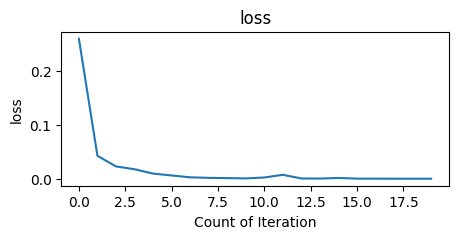

In [19]:
# Plot loss
plotHistory(history.history['loss'],'loss')

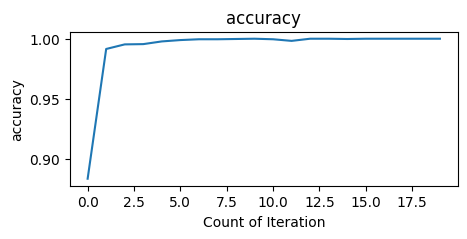

In [20]:

# Plot accuracy
plotHistory(history.history['accuracy'],'accuracy')

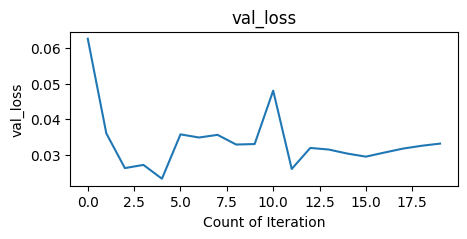

In [21]:
# Plot validation loss
plotHistory(history.history['val_loss'],'val_loss')

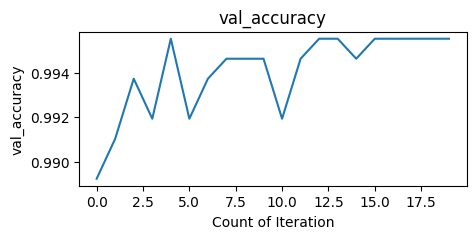

In [22]:
# Plot validation accuracy
plotHistory(history.history['val_accuracy'],'val_accuracy')

In [23]:
# Predict the bert model
pred_lebel = bert_model.predict(test_inputs)

35/35 [==============================] - 126s 4s/step


In [24]:
# Show the actual prediction
print(pred_lebel)

TFSequenceClassifierOutput(loss=None, logits=array([[ 4.8934054, -4.0549617],
       [ 4.8464046, -4.009148 ],
       [ 5.0030665, -4.1547647],
       ...,
       [ 4.9718804, -4.1379294],
       [ 4.5221963, -3.6488385],
       [ 4.9756866, -4.122873 ]], dtype=float32), hidden_states=None, attentions=None)


In [25]:
# Important part of prediction
pred_lebel.logits 

array([[ 4.8934054, -4.0549617],
       [ 4.8464046, -4.009148 ],
       [ 5.0030665, -4.1547647],
       ...,
       [ 4.9718804, -4.1379294],
       [ 4.5221963, -3.6488385],
       [ 4.9756866, -4.122873 ]], dtype=float32)

35/35 [==============================] - 104s 3s/step


<Figure size 100x100 with 0 Axes>

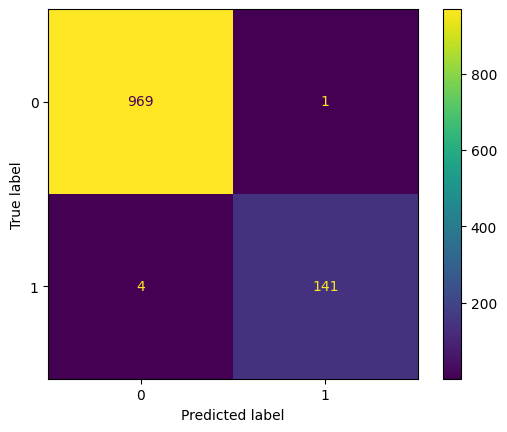

In [40]:

# Import and show the result
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Define predicted labels
predicted_labels = bert_model.predict(test_inputs).logits.argmax(axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_labels, labels=[0,1])

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
plt.figure(figsize=(1,1))
disp.plot()
plt.show()


In [34]:

# Plot the result
cm = confusion_matrix(test_labels, predicted_labels, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
plt.figure(figsize=(1,1))
disp.plot()
plt.show()

NameError: name 'predicted_labels' is not defined

In [41]:

# Accuracy score
accuracy_score(test_labels, predicted_labels)

0.9955156950672646

In [42]:
print(encoded_inputs)

{'input_ids': <tf.Tensor: shape=(5572, 128), dtype=int32, numpy=
array([[  101,  2175,  2127, ...,     0,     0,     0],
       [  101,  7929,  2474, ...,     0,     0,     0],
       [  101,  2489,  4443, ...,     0,     0,     0],
       ...,
       [  101, 12063,  1010, ...,     0,     0,     0],
       [  101,  1996,  3124, ...,     0,     0,     0],
       [  101, 20996, 10258, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(5572, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(5572, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}


In [52]:
message = "This is reminder for submission of your task that given.Submit it as soon as possible"
encoded_message = tokenizer(message, padding=True, truncation=True, max_length=max_length, return_tensors='tf')

# Convert BatchEncoding object to tuple of tensors
encoded_message = tuple(encoded_message[key] for key in encoded_message)

# Predict the bert model
pred_lebel = bert_model.predict(tf.data.Dataset.from_tensor_slices(encoded_message).batch(1))

print(pred_lebel)

if pred_lebel[0][0][0] > pred_lebel[0][0][1]:
  print("This is a ham message")
else:
    print("This is a spam message")




1/1 [==============================] - 2s 2s/step
TFSequenceClassifierOutput(loss=None, logits=array([[ 4.8485484, -4.013886 ]], dtype=float32), hidden_states=None, attentions=None)
This is a ham message


In [56]:
def detect_content(message):
    encoded_message = tokenizer(message, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
    # Convert BatchEncoding object to tuple of tensors
    encoded_message = tuple(encoded_message[key] for key in encoded_message)
    pred_lebel = bert_model.predict(tf.data.Dataset.from_tensor_slices(encoded_message).batch(1))
    if pred_lebel[0][0][0] > pred_lebel[0][0][1]:
        # print("This is a ham message")
        return 1
    else:
        # print("This is a spam message")
        return 0
    
    

In [65]:
message = '''Dear Ma’am,

 

Greetings from Saptang Labs!

 

Nice Connecting with you today!

As per our discussion, with reference to the Internship Program with our company, please find the attached certificates of the following students
We are pleased to know that the students are ready to give us the demo session on the completed project. We shall schedule the time slot and revert on the same.

 

Further, in case of any queries, please feel free to reach out to us.
'''
result=detect_content(message)
if result==0:
    print("This is a spam message")
else:
    print("This is a ham message")

1/1 [==============================] - 0s 126ms/step
This is a ham message


In [68]:
bert_model.save_pretrained('./model/')

In [69]:
model2 = TFBertForSequenceClassification.from_pretrained('./model/')
model2.summary()

Some layers from the model checkpoint at ./model/ were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_75 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [70]:
def detect_content1(message):
    encoded_message = tokenizer(message, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
    # Convert BatchEncoding object to tuple of tensors
    encoded_message = tuple(encoded_message[key] for key in encoded_message)
    pred_lebel = model2.predict(tf.data.Dataset.from_tensor_slices(encoded_message).batch(1))
    if pred_lebel[0][0][0] > pred_lebel[0][0][1]:
        # print("This is a ham message")
        return 1
    else:
        # print("This is a spam message")
        return 0

In [71]:
result=detect_content1(message)
if result==0:
    print("This is a spam message")
else:
    print("This is a ham message")

1/1 [==============================] - 2s 2s/step
This is a ham message
